<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>SARSA in GridWorld</strong></h2>
</div> 

&nbsp;

**Goal:** Learn a policy that maximizes expected long-term return in a stochastic GridWorld this time using **SARSA(0)**, an on-policy TD control method.

---

### Why SARSA?
**SARSA (State-Action-Reward-State_action)** is an **on-policy, model-free** algorithm. Unlike Q-Learning (which is off-policy and backs up using a greedy *max* over next actions), SARSA backs up using **the very next action the agent actually takes** under its current behavior policy (typically ε-greedy). In noisy worlds, this often yields **safer** policies that account for the exploration the agent will continue to do.

---

### Interaction Loop (on-policy)
At each step the agent:

1. Observes current state $(s)$
2. Chooses action $(a \sim \pi_\epsilon(\cdot \mid s)$ (ε-greedy)
3. Receives reward $(r)$
4. Transitions to the next state $(s')$
5. **Chooses next action** $(a' \sim \pi_\epsilon(\cdot \mid s')$ (on-policy)
6. Updates how good $(s, a)$ is using $(r)$ and the estimate $Q(s', a')$

---

The **return** is the dicounted sum of future rewards:

$$
G_t = \sum_{k=0}^{\infty} \gamma^{k}\, r_{t+k+1}
$$

with discount $\gamma \in [0, 1]$ controlling farsightedness.

---

### Action-Value Function
SARSA learns the **action-value function** $Q^\pi(s, a)$: the expected return startin in $(s)$, taking $(a)$, and **thereafter following the same policy $(\pi)$** (here, ε-greedy).

If we had the true $Q^\star$, the greedy action would be:

$$
\pi^\star(s) = \arg\max_a Q^\star(s, a)
$$

---

### The Bellman Extepcastion Equation (On-Policy)

For a fixed policy $(\pi)$,

$$
Q^\pi(s, a) = \mathbb{E}\!\left[\, R_{t+1} + \gamma \, Q^\pi(S_{t+1}, A_{t+1} \, \middle|\, S_t{=}s, A_t{=}a, A{t+1}\!\sim\!\pi \right]
$$

SARSA performs **sample-based** updates toward this on-policy target.

---

### SARSA(0) Update Rule

$$
\boxed{ \;
Q(s, a) \leftarrow Q(s, a) + \alpha \Big[\, r + \gamma \, Q(s', a') - Q(s, a) \, \Big]
\;}
$$

**Symbols**

| Symbol | Meaning |
|---|---|
| $(s, a)$ | Current state and chosen action |
| $(r)$ | Immediate reward after taking $a$ in $s$ |
| $(s', a')$ | Next state and **next action chosen by the same ε-greedy policy** |
| $(\alpha)$ | Learning rate (step size) |
| $(\gamma)$ | Discount factor |
| **TD error** | $(\delta = r + \gamma Q(s',a') - Q(s,a))$ |


**Key contrast with Q-Learning:**
Q-Learning uses the **greedy target** $(r + \gamma \max{a'} Q(s', a')$ (off-policy}, while SARSA uses the **behavior action** $(a')$ (on-policy). In stochastic domains, SARSA's backups reflect the risk incurred by $\varepsilon\text{-greedy}$ exploration, often yielding more conservative paths.

---

### Exploration vs Exploitation (on-policy)

We use an **$\varepsilon\text{-greedy}$** behavior\target policy $(\pi_\epsilon)$: 

- With probability $(\epsilon)$: pick a random action (explore)
- With probability $(1-\epsilon)$: pick $(\arg\max_a Q(s, a)$ (exploit)
- $(\epsilon)$ typically **decays** from 1.0 to a small floor, so early training explores widely and later focus on exploitation.

---

### Intuitive Summary

| Concept | Analogy |
|---|---|
| Q-table | A map: for each state, how good is each move? |
| TD Error | Surprise: how different was the outcome from our prediction? |
| Learning rate $(\alpha)$ | How quickly we correct the map |
| Discount $(\gamma)$ | How farsighted the agent is |
| ε (curiosity) | How often we keep “trying new roads” |

**Heuristic:** In windy/stochastic GridWorlds, SARSA often learns reoutes that **avoid risky edges** because its updates account for the fact that the agent will still take exploratory actions in the future.

## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [18]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    from rl_capstone.rl_algorithms import TrainConfig, sarsa_train_with_logs
    from rl_capstone.utils import (
    evaluate_policy,
    greedy_policy_from_0,
    plot_learning_curve,
    EpisodeLog,
    greedy_action,
    run_greedy_episode,
    rolling,
    idx_traj_to_rc_path,
    value_grid,
    plot_value_and_policy,
)

    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Action4, Grid=11x11



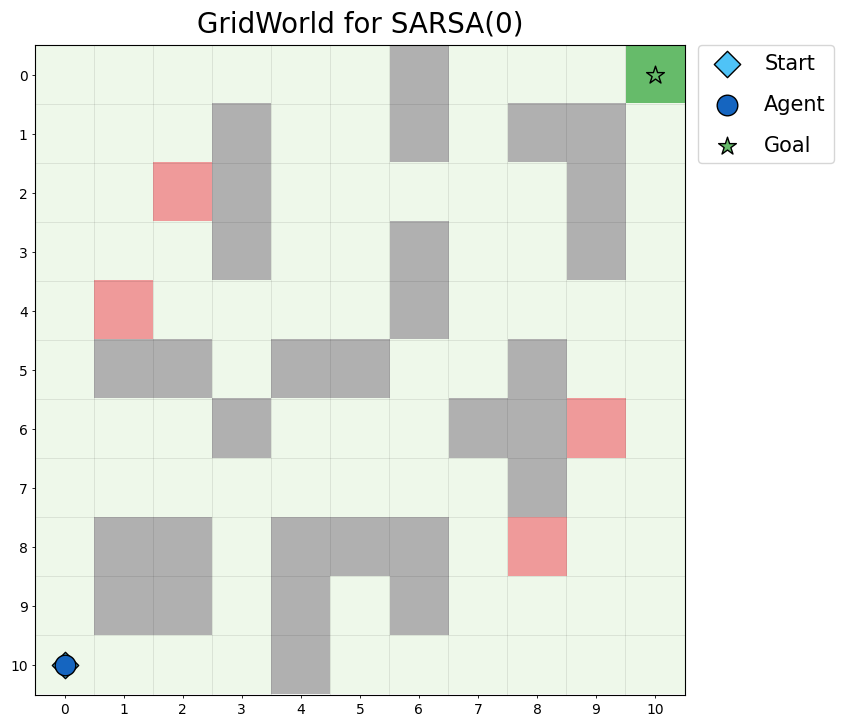

In [19]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Action{env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld for SARSA(0)")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [20]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration SARSA + plot learning curve

In this section the user can set up the configurations needed for training the agent. As well as visualize how the agent is learning by plotting a `Learning Curve`, which shows the number of episodes with respect to the `Return` the agent experienced in the algorithm with the respective configurations.

In [25]:
# Same constants as other models
cfg_sarsa = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

Q_sarsa, logs_sarsa = sarsa_train_with_logs(env, cfg, logcfg)
print(f"{GREEN}SARSA Training complete.{RESET}")

SARSA Training complete.



Evaluation — mean return over 30 episodes: 0.775, mean steps: 23.5



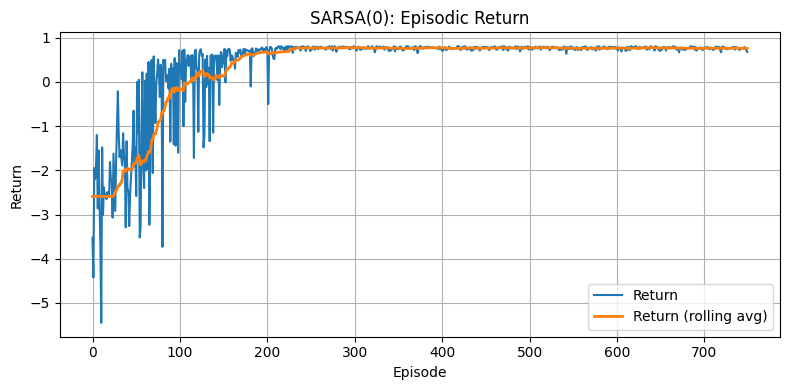

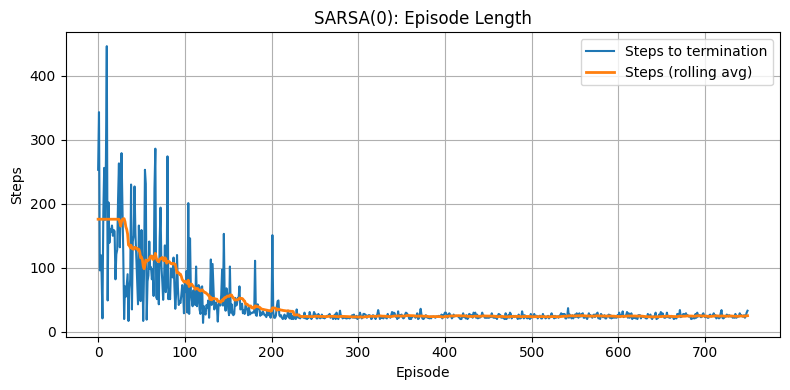

In [26]:
pi_sarsa = greedy_policy_from_0(Q_sarsa)
mean_return, mean_len = evaluate_policy(env, pi_sarsa, episodes=30, max_steps=1000, seed=123)
print(f"\nEvaluation — mean return over 30 episodes: {mean_return:.3f}, mean steps: {mean_len:.1f}\n")

# -- Sarsa: Return Curve --
plt.figure(figsize=(8,4))
plt.plot(logs_sarsa["returns"], label="Return")
plt.plot(rolling(logs_sarsa["returns"], 25), label="Return (rolling avg)", linewidth=2)
plt.title("SARSA(0): Episodic Return");
plt.xlabel("Episode");
plt.ylabel("Return")
plt.grid(True);
plt.legend();

plt.tight_layout()
plt.savefig("../reports/figs/sarsa/sarsa_return.png", dpi=300, bbox_inches="tight")
plt.show()

# -- Sarsa: Episode Length --
plt.figure(figsize=(8,4))
plt.plot(logs_sarsa["steps"], label="Steps to termination")
plt.plot(rolling(logs_sarsa["steps"], 25), label="Steps (rolling avg)", linewidth=2)
plt.title("SARSA(0): Episode Length");
plt.xlabel("Episode");
plt.ylabel("Steps")
plt.grid(True);
plt.legend();

plt.tight_layout()
plt.savefig("../reports/figs/sarsa/sarsa_steps.png", dpi=300, bbox_inches="tight")
plt.show()


## 5) Snapshots of Agent's Trajectory
This section converts each trajectory of state indices into `(row, col)` and overlay it as a path.
This gives you **several images** across training showing the agent getting better.

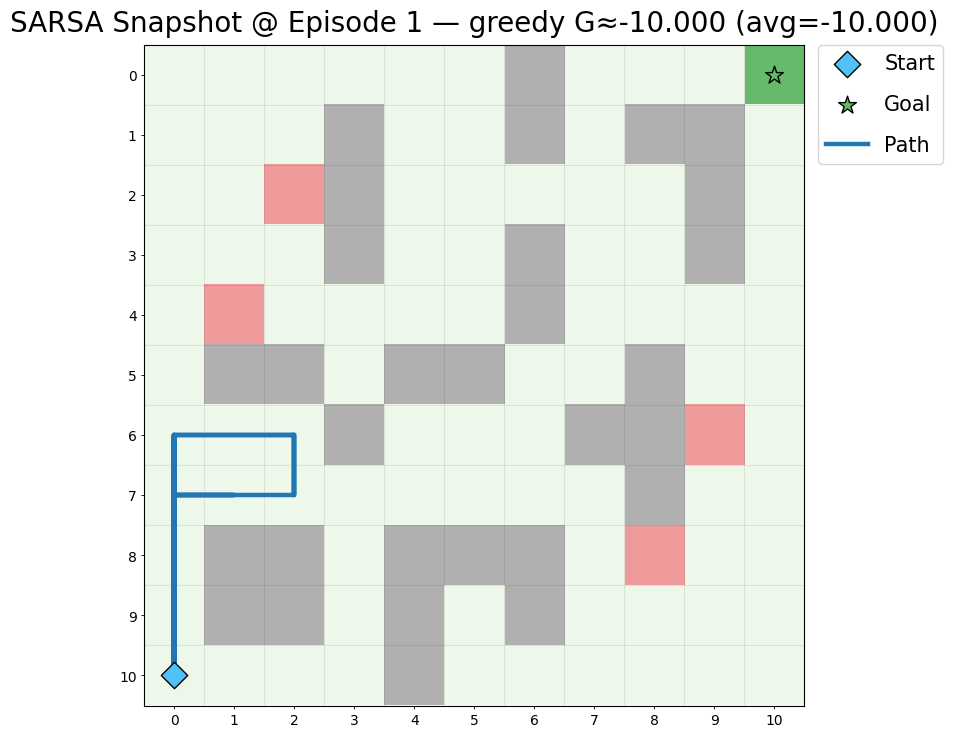

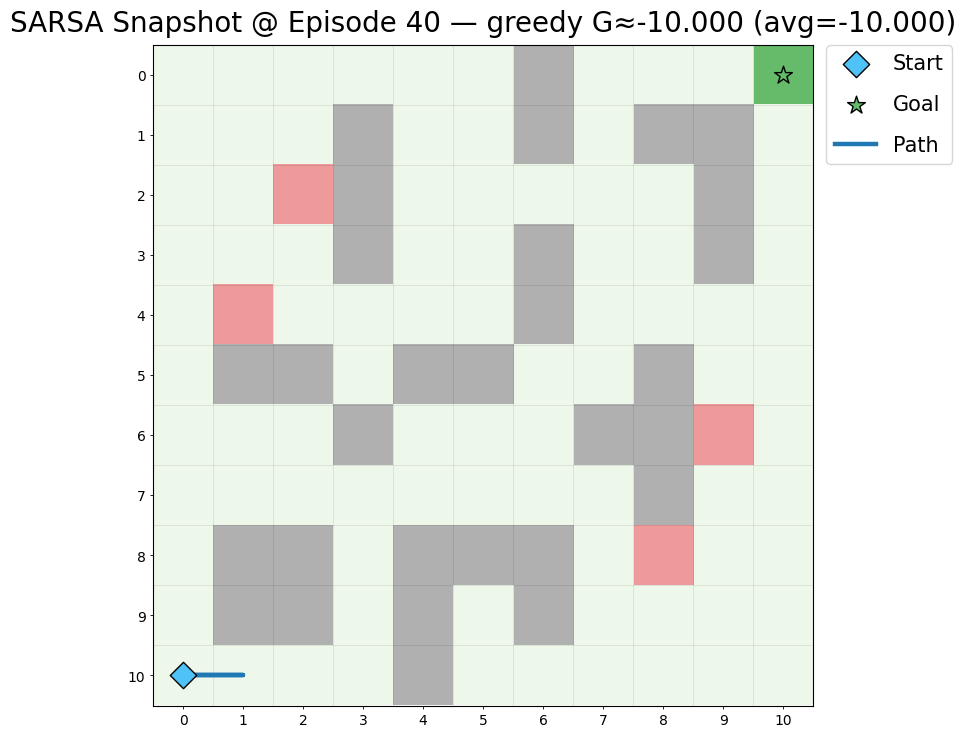

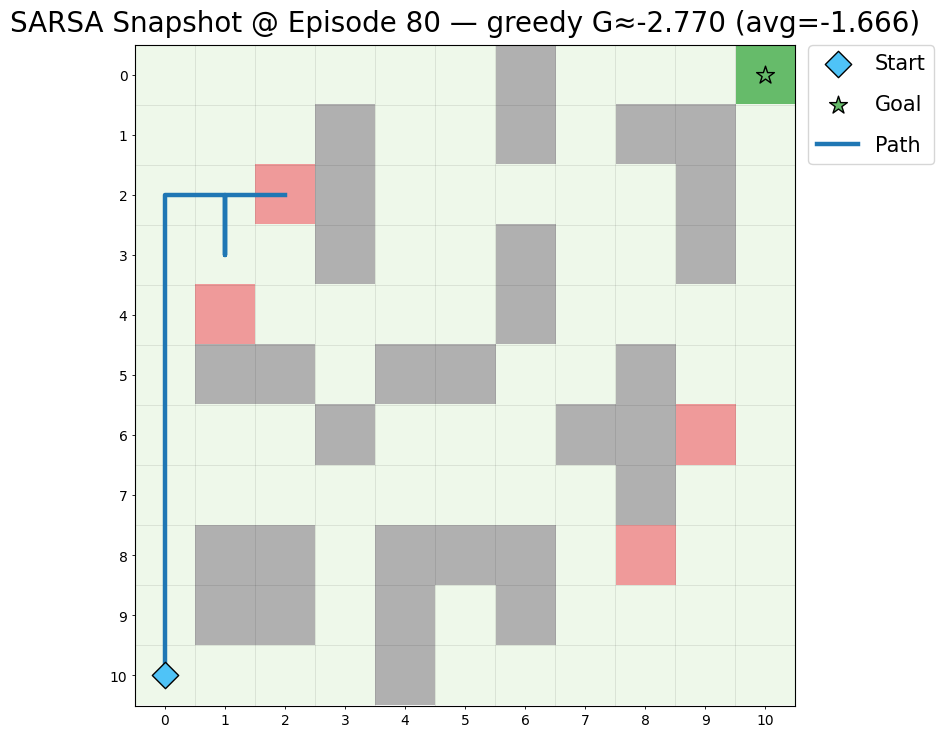

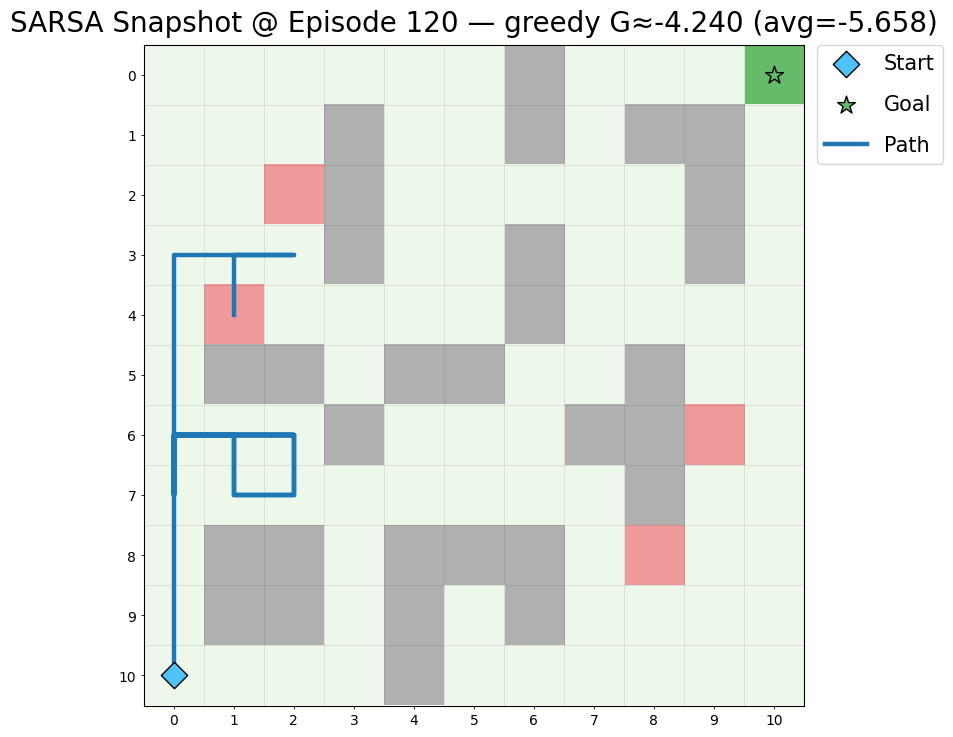

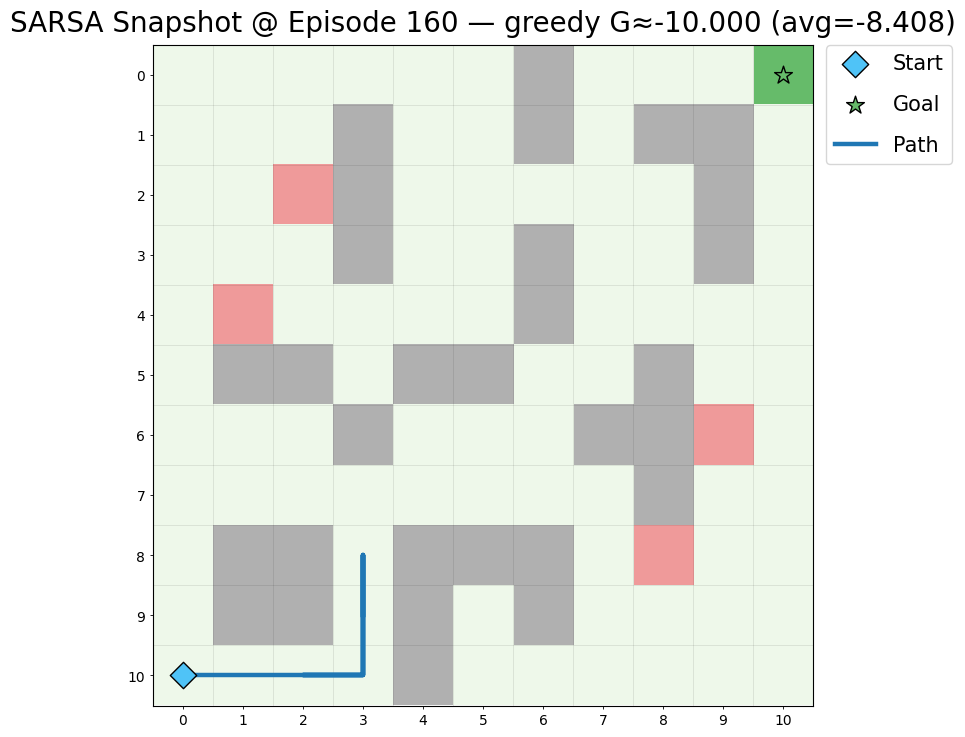

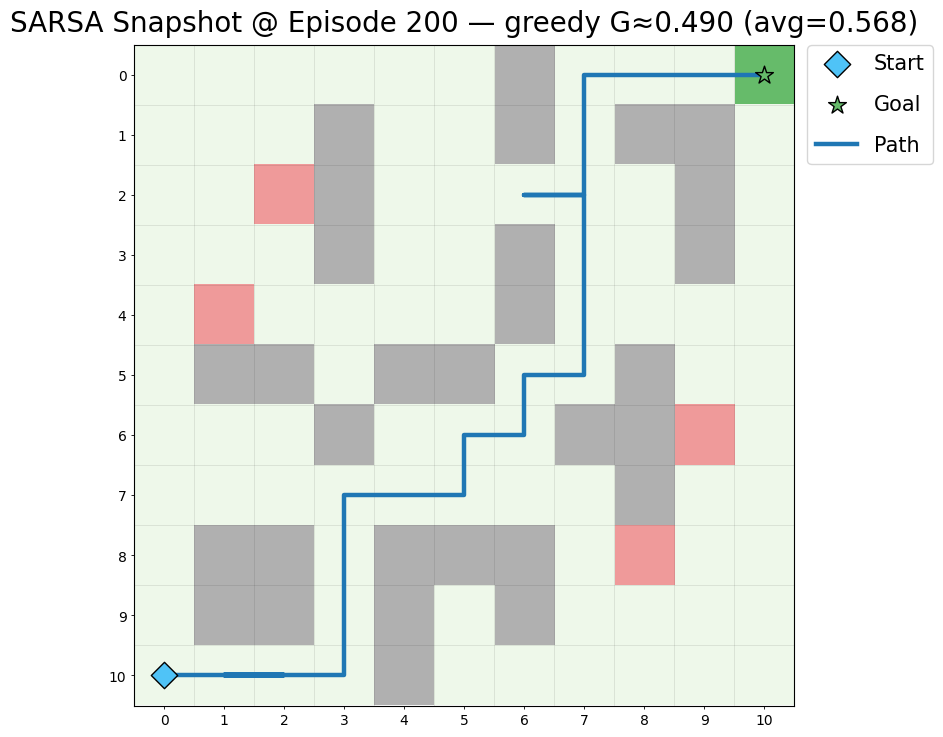

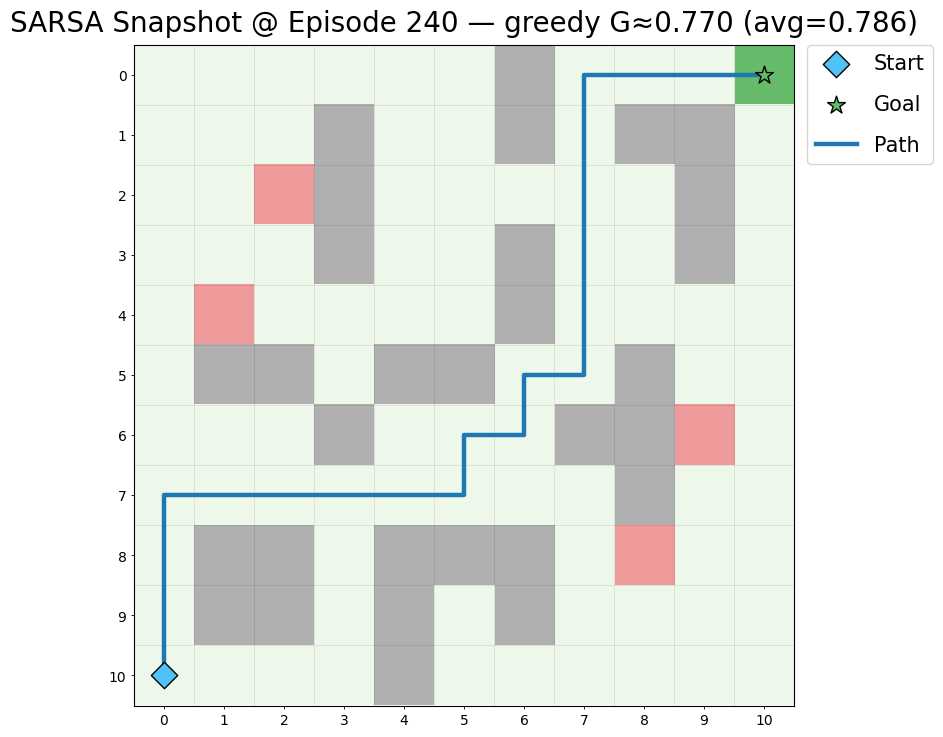

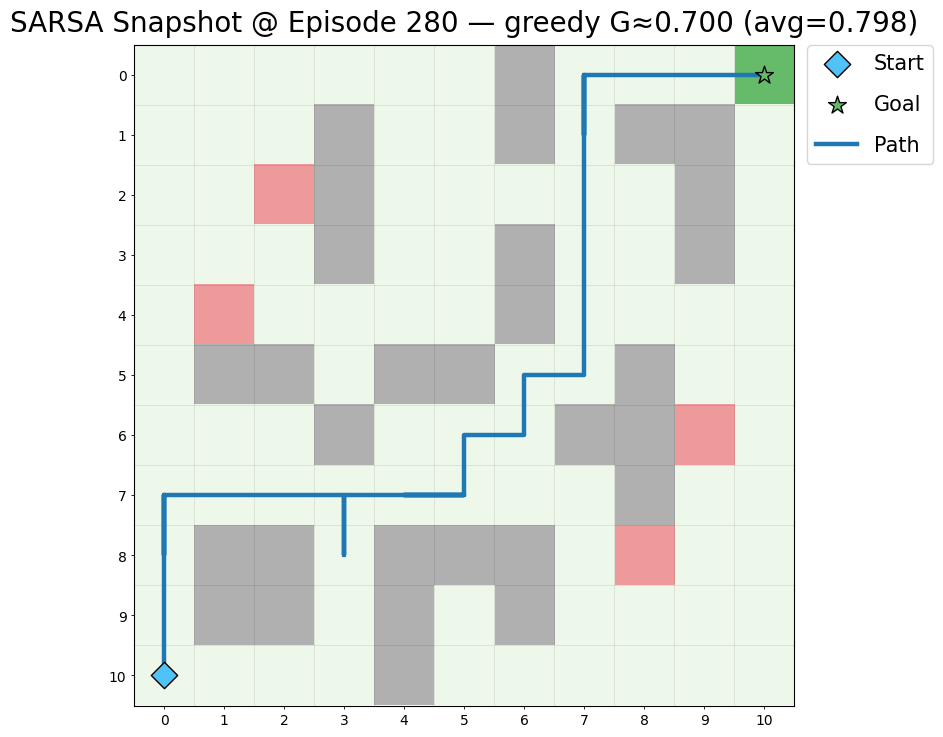

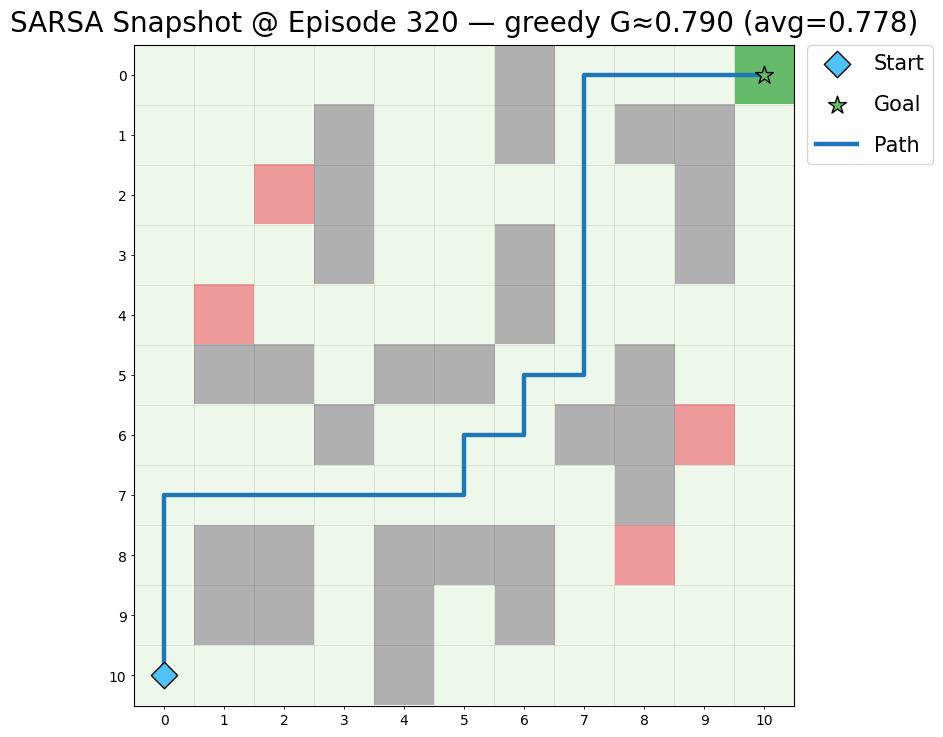

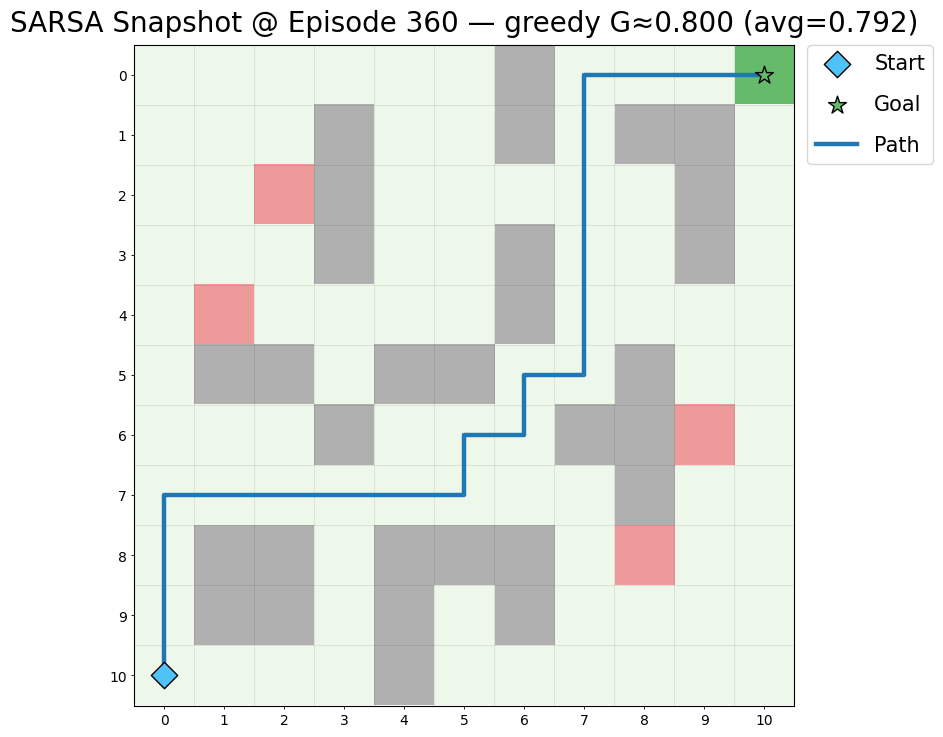

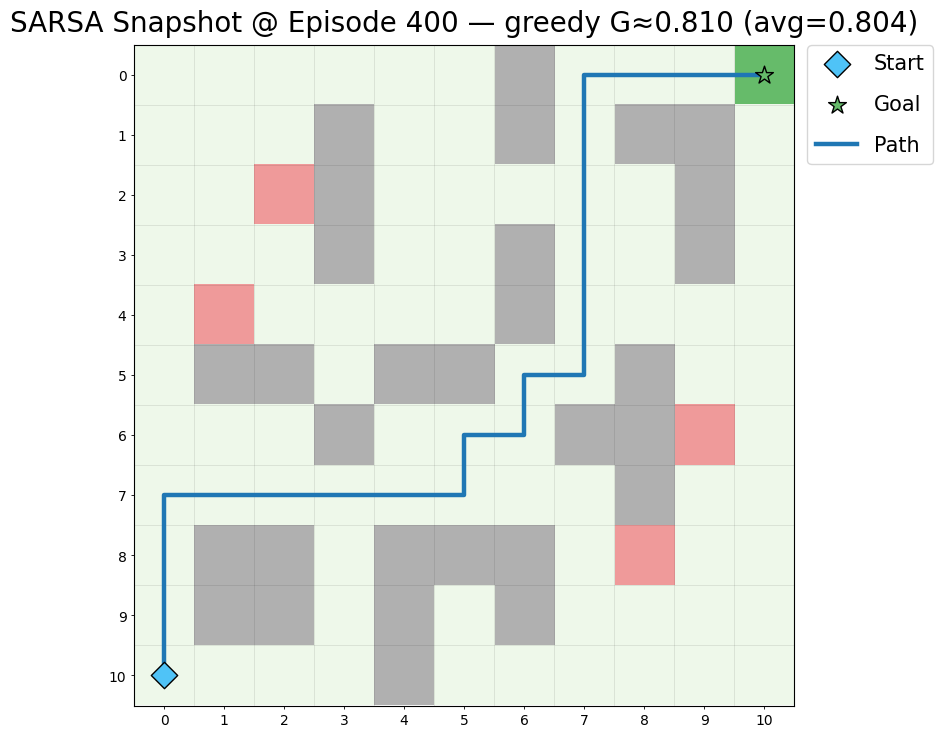

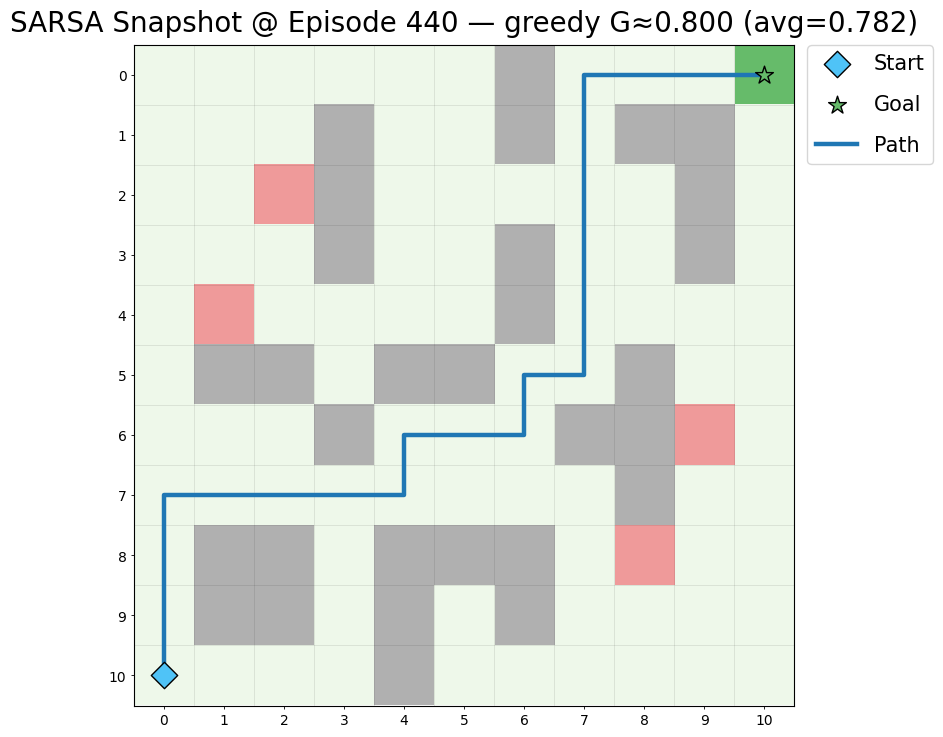

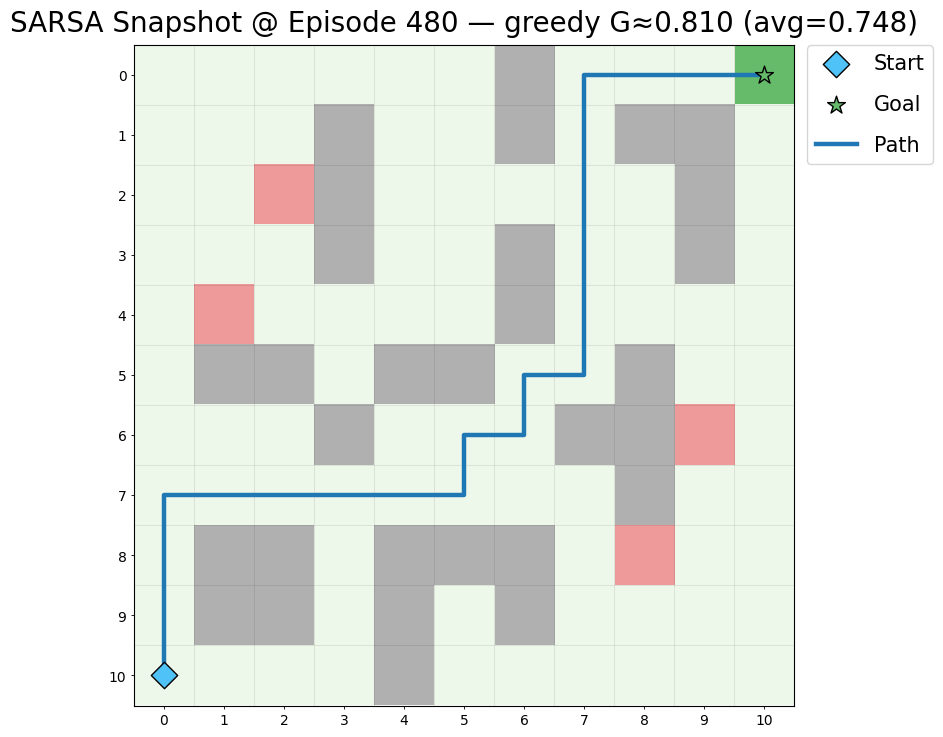

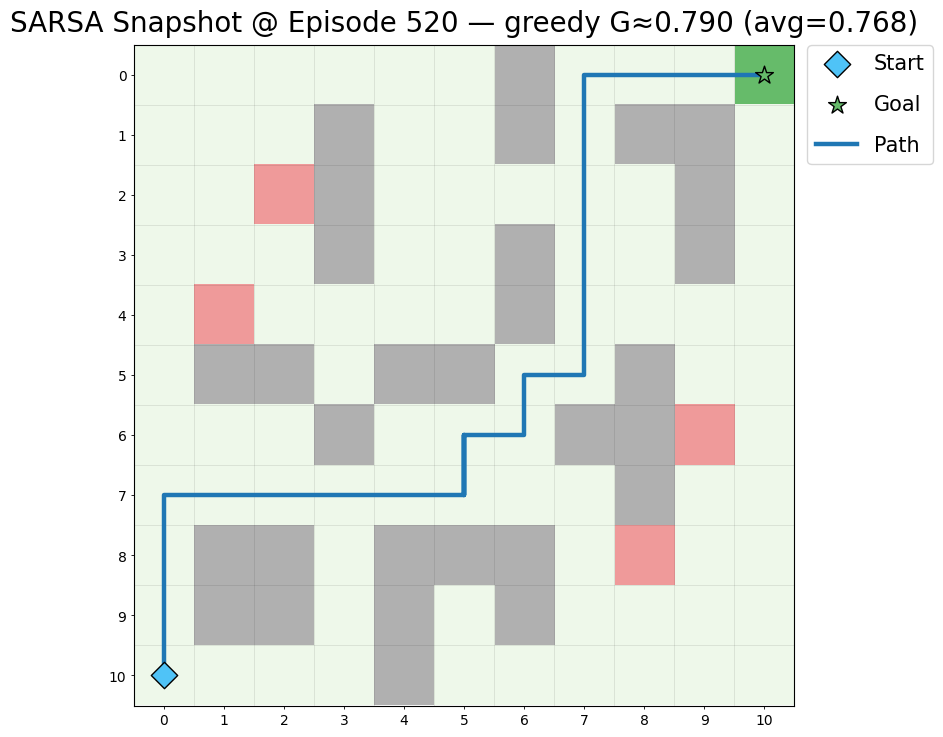

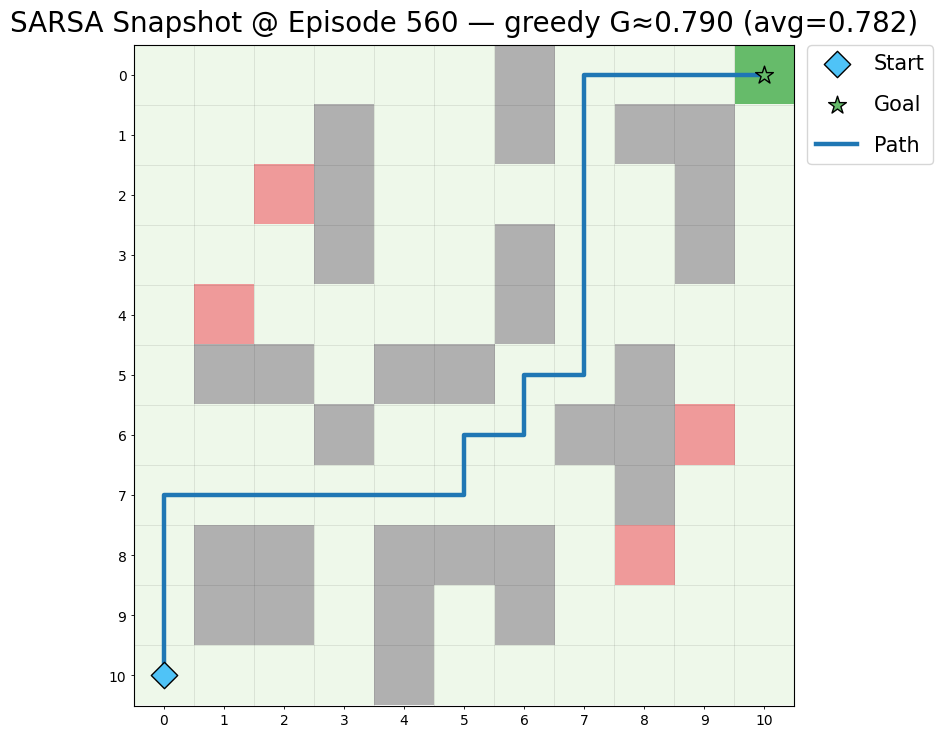

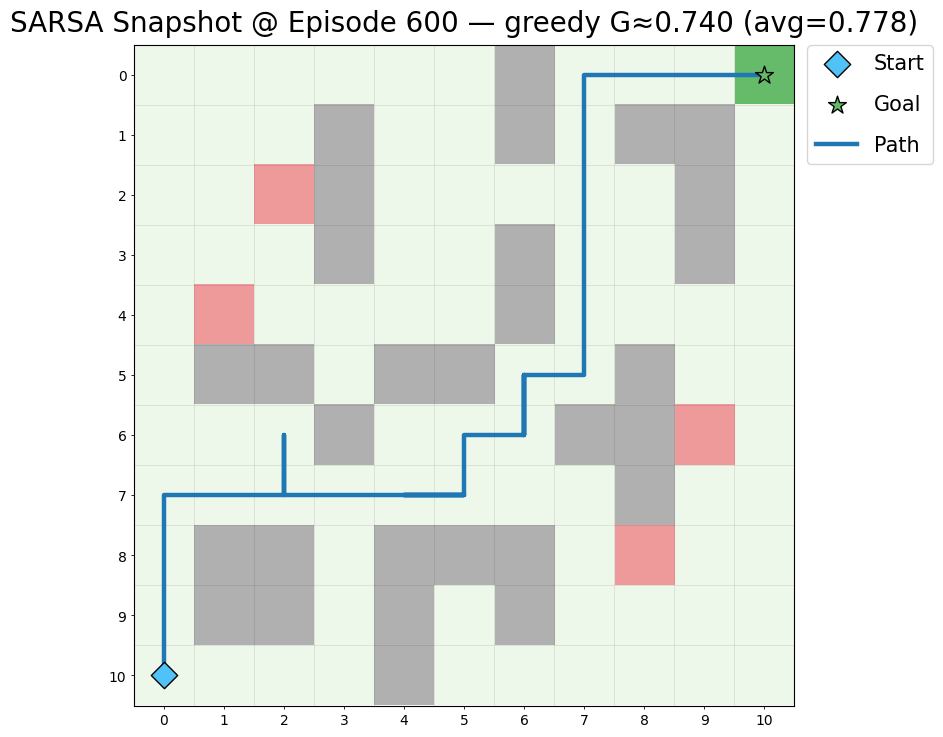

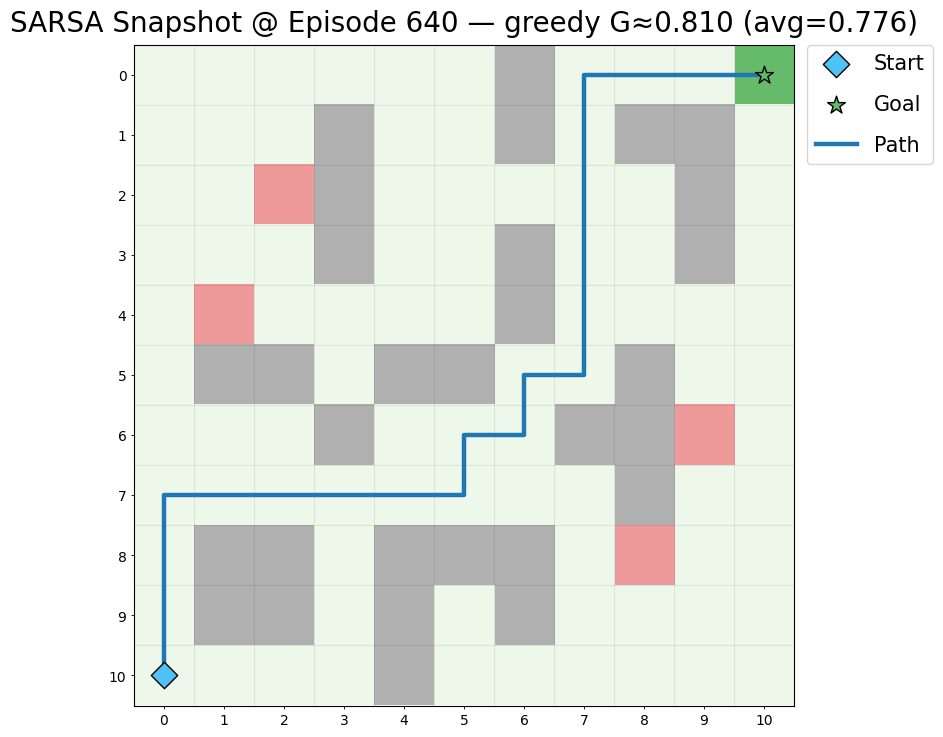

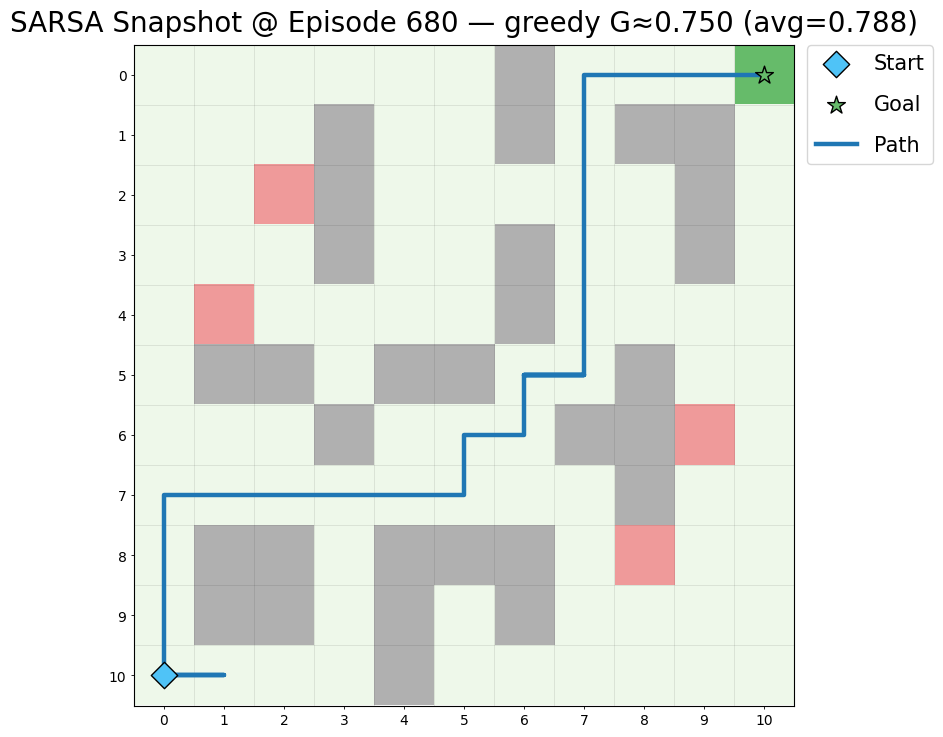

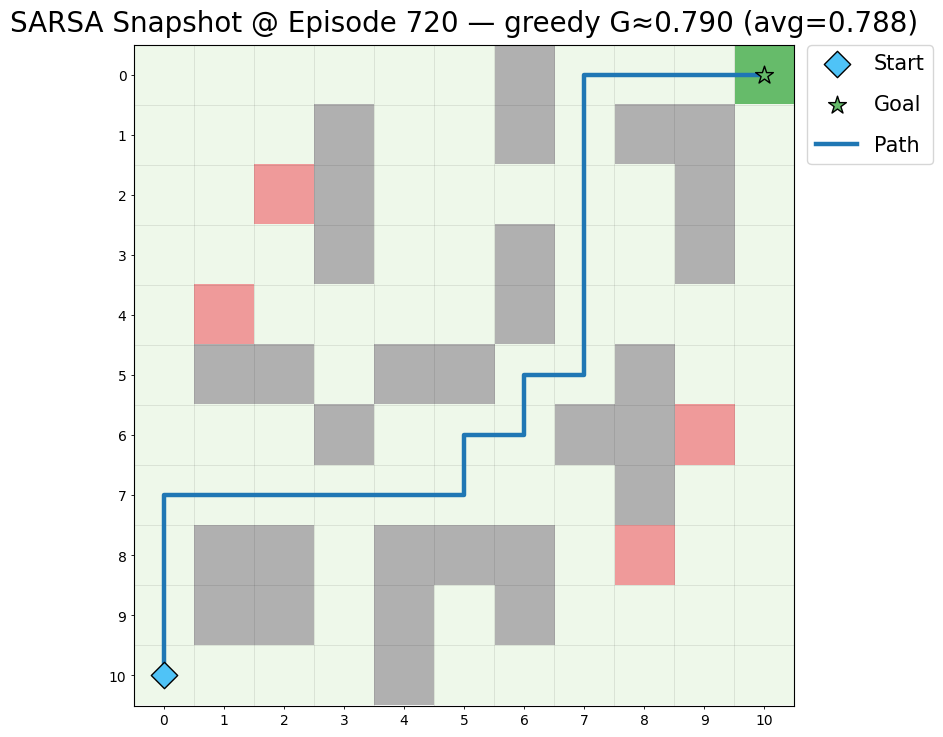

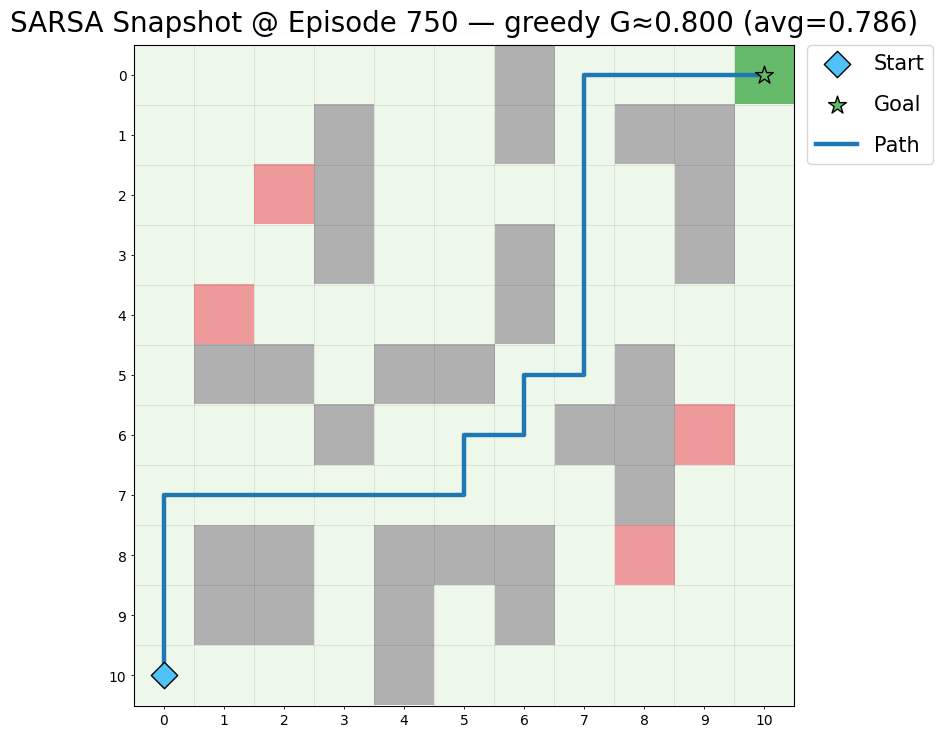

In [27]:
# Snapshots
for snap in logs_sarsa["snapshots"]:
    ep = snap["episode"]
    Q_snap = snap["Q"]
    avg_ret = snap["avg_return"]

    # Run one greedy episode from this snapshot
    G_snap, traj_idx = run_greedy_episode(env, Q_snap, max_steps=cfg_sarsa.max_steps)
    path_rc = idx_traj_to_rc_path(env, traj_idx)

    env.reset()
    env.render(
        path=path_rc,
        show_agent=False,
        title=f"SARSA Snapshot @ Episode {ep} — greedy G≈{G_snap:.3f} (avg={avg_ret:.3f})"
    )

## 6) Final Path
This section prints the last outcome from the algorithm, showing the "most" optimal output. It provides the average `result` and `steps` the agent took during the algorithm.

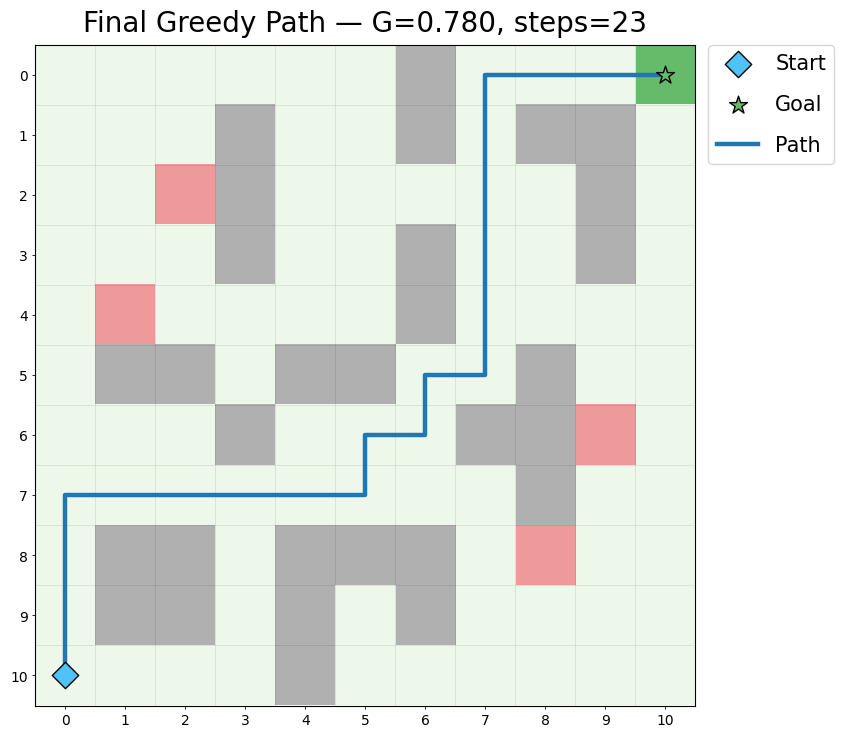

In [28]:
# Final Optimal Greedy Path
G_final, traj_final = run_greedy_episode(env, Q_sarsa, max_steps=cfg_sarsa.max_steps)
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final),
    show_agent=False,
    title=f"Final Greedy Path — G={G_final:.3f}, steps={len(traj_final)-1}"
)

## 7) Policy / Value heatmap with arrows

Heat maps are used to visualize what is the trajectory that the agent took the most in order to find the "most" optimal greedy path.

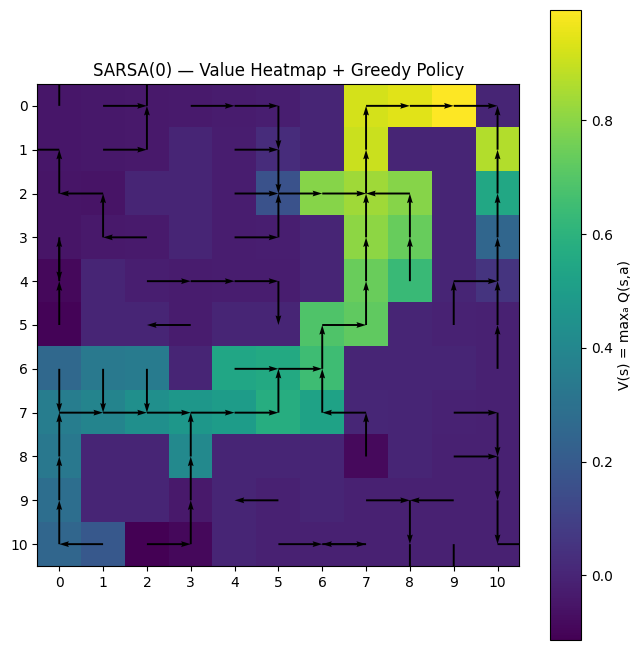

In [29]:
# Final SARSA visualization heatmap
plot_value_and_policy(env, Q_sarsa, title="SARSA(0) — Value Heatmap + Greedy Policy")

### Conclusion

The results illustrate the defining characteristics of **SARSA(0)** as an on-policy learning algorithm. Steadily improving both cumulative return and path efficiency while learning from the **actions it actually takes**, including exploratory ones.

* **Episodic Return:** As in Q-Learing, early episodes yield strongly negative returns since the agent begins with uninformed behavior, often wandering into pits or cycling aimlessly under $\varepsilon\text{-greedy}$ exploration. Over time, the returns rise as the Q-values stabilize and $\varepsilon$ decays, reflecting the agent's growing ability to reach the goal consistently. However, the learning curve for **SARSA** typically increases **more gradually** than Q-Learning's, since updates are tied to the current policy's actual $(\varepsilon\text{-greedy})$ behavior rather than an optimistic max over future actions. This leads to slightly slower convergence but more stable learning in stochastic settings.
  
* **Episode Length:** The number of steps per episode decreases markedly after roughtly **120 - 150 episodes**. The agent not only discovers successful routes but also begins to refine them, avoiding dead ends, risky edges near pits, and long detours. Compared to Q-Learning, the decline in episode length is smoother and less abrupt, consistent with SARSA's tendency toward **safer, more conservative paths**.

* **Final Policy and Value Function:** The value heatmap shows a smooth gradient of increasing value toward the goal, with high-value regions forming a clear corridor that bypasses walls and pits. The greedy policy arrows trace an intuitive route from the start (bottom-left) to the goal (top-right), hugging safer interior corridors instead of risky outer edges. This indicates that SARSA has converged to a new-optimal but slightly more risk-averse-policy that performs well under the enviroment's stochastic "wind"

* **Greedy Path Visualization:** The final rendered trajectory confirms this behavior: the agent reaches the goal reliably within a small number of steps (=25 - 30) and accumulates a total return close to **0.75 - 0.8**, depending on random wind perturbations. While slightly less aggressive than the Q-Learning path, the SARSA agent exhibits smoother, more consistent motion, demonstrating the hallmark of on-policy learning: **robustness through cautious adaption to exploration noise**.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="01_q_learning.ipynb">
    <button class="button">
      ⬅️ Prev: Q-Learning
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="03_dyna_q.ipynb">
    <button class="button">
      Next: Dyna-Q ➡️
    </button>
  </a>
  
</div>
